In [1]:
import numpy as np
import os
import h5py
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

/home/bisp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

Using TensorFlow backend.


# Data Generators

In [208]:
class DataGenerator(keras.utils.Sequence):
    
    def truncate_k_space(self, data):
        n = self.x_dims[0]
        trunc_data = data[:,int((1-self.sampling_percent)*n//2):
                            int((1+self.sampling_percent)*n//2), :]
        return trunc_data
    
    'Generates data for Keras'
    def __init__(self, dataset, filename, X_identifier, Y_identifier, 
                 batch_size, sampling_percent=1, shuffle=True):
        super(DataGenerator,self).__init__()
        
        with h5py.File(filename+'.h5', 'r') as hf:
            keys = list(hf.keys())
            # Get dimensions of the input space
            temp = [i for i in keys if dataset+'_'+X_identifier in i]
            x_dims = hf[temp[0]].shape[1::]
            num_files = len(temp)
            # Get dimensions of the output space
            temp = [i for i in keys if dataset+'_'+Y_identifier in i]
            y_dims = hf[temp[0]].shape[1::]
        
        # The batch size
        self.batch_size = batch_size
        self.num_files = num_files
        # Assumes the file ids are always from 0 to num_files
        self.file_ids = list(range(num_files))
        # Calculate the number of batches
        self.num_batches = int(num_files)
        
        self.filename = filename
        self.dataset = dataset 
        self.X_identifier = X_identifier
        self.Y_identifier = Y_identifier
        
        # Dimensions of the input and the output
        self.x_dims = x_dims
        self.y_dims = y_dims
        self.input_shape = (int(x_dims[0]*sampling_percent),) + x_dims[1:]
        
        self.sampling_percent = sampling_percent
        self.shuffle = shuffle
        if shuffle is True: self.on_epoch_end()
        
    def __len__(self):
        """Number of batch in the Sequence.
        
        Returns
            The number of batches in the Sequence.
        """
        return self.num_batches

    def __getitem__(self, index):
        """Gets batch at position `index`.
        Arguments
            index: position of the batch in the Sequence.
        Returns
            A batch
        """        
        X = np.zeros((self.batch_size,) + self.x_dims)
        Y = np.zeros((self.batch_size,) + self.y_dims)
        
        with h5py.File(self.filename+'.h5', 'r') as hf:
            
            # Input and output identifiers
            x_id = self.dataset + '_' + \
                    self.X_identifier + '_' + str(self.file_ids[index])
            y_id = self.dataset + '_' + \
                    self.Y_identifier + '_' + str(self.file_ids[index])
                
            X = np.asarray(hf[x_id])
            Y = np.asarray(hf[y_id]) 
        
        X = self.truncate_k_space(X)
        X = np.stack((np.real(X), np.imag(X)), axis=-1)
        X = X.astype('float32')
        X = X/np.max(X)
        X = X.reshape(X.shape)   
        # Convert class vectors to binary class matrices. This uses 1 hot encoding.
        num_classes = 2
        Y = keras.utils.to_categorical(Y, num_classes)
        return X, Y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.file_ids)
            
    def get_data(self, index, identifier, indices):
        
        with h5py.File(self.filename+'.h5', 'r') as hf:
            data_id = self.dataset + '_' + \
                    identifier + '_' + str(self.file_ids[index])
            
            data = np.asarray(hf[data_id])[indices]
        if identifier == 'k_space': data = self.truncate_k_space(data)
        return data
    
    def get_data_all(self, identifier):
        data = None
        with h5py.File(self.filename+'.h5', 'r') as hf:
            for file_id in range(self.num_files):
                data_id = self.dataset + '_' + \
                    identifier + '_' + str(file_id)
                
                if data is None: data = np.asarray(hf[data_id])
                else: data = np.vstack((data, np.asarray(hf[data_id])))
        if identifier == 'k_space': data = self.truncate_k_space(data)
        return data

In [190]:
dataset = 'test'
filename = 'datasets//data_tumor_TEST_batch'
X_identifier = 'k_space'
Y_identifier = 'label'
batch_size = 32
sampling_percent = 0.0625
shuffle = False
example_generator = DataGenerator(dataset, filename, 
                                  X_identifier, Y_identifier, 
                                  batch_size, sampling_percent,
                                  shuffle)

In [191]:
print(example_generator.input_shape)
print(example_generator.get_data(0,'k_space',[1,2,3,4]).shape)

(8, 128)
(4, 8, 128)


# Create generators 

In [245]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

Create the generators

In [264]:
name = 'data_tumor_size5_large'
# Sampling percents
# 128 = 1, 64 = 0.5, 32 = 0.25, 16 = 0.125, 
# 8 = 0.0625, 4 = 0.03125, 2 = 0.015625
sampling_percent = 1#0.0625
# Generators
filename = 'datasets//' + name
X_identifier = 'k_space'
Y_identifier = 'label'
batch_size = 32
training_generator = DataGenerator('train', filename, 
                                   X_identifier, Y_identifier, 
                                   batch_size, sampling_percent, False)
validation_generator = DataGenerator('validation', filename, 
                                     X_identifier, Y_identifier, 
                                     batch_size, sampling_percent, False)

input_shape = training_generator.input_shape + (2,)
num_classes = 2
print('Input shape: ', input_shape)

Input shape:  (128, 128, 2)


# Select Model

2x2 kernels

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2),
                 activation='relu',
                 padding = 'same',
                 input_shape=input_shape))
model.add(Conv2D(64, (2, 2), padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Standard CNN with 3x3 models

In [265]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 padding = 'same',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

/home/bisp/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:477: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


DNN to be used when the input space is not wide enough to apply a kernel.

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Provides a summary of the model used.

In [266]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 128, 128, 32)      608       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 262144)            0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                16777280  
_________________________________________________________________
dropout_36 (Dropout)         (None, 64)                0         
__________

Get the memory usage of the model.

In [267]:
get_model_memory_usage(32, model)

2.284

Fit the model

In [ ]:
if not os.path.exists('weights//'+name):
    os.makedirs('weights//'+name)

# Save the model
model_json = model.to_json()
with open('weights//' + name + '//' + name + '_model.json', "w") as json_file:
    json_file.write(model_json)

# Save the weights using a checkpoint.
filepath='weights//' + name + '//weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

epochs = 100
# Fit the model weights.
history = model.fit_generator(generator=training_generator,
                              steps_per_epoch=training_generator.num_batches,
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.num_batches)

/home/bisp/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:477: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


Epoch 1/100
1797/1797 [==============================] - 86s 48ms/step - loss: 0.6352 - acc: 0.6242 - val_loss: 0.5426 - val_acc: 0.7270
Epoch 2/100
1797/1797 [==============================] - 88s 49ms/step - loss: 0.5232 - acc: 0.7369 - val_loss: 0.4775 - val_acc: 0.7618
Epoch 3/100
1797/1797 [==============================] - 562s 313ms/step - loss: 0.4769 - acc: 0.7703 - val_loss: 0.4387 - val_acc: 0.7895
Epoch 4/100
1373/1797 [=====================>........] - ETA: 2:16 - loss: 0.4535 - acc: 0.7831

# Analyze results

Plot the loss and accuracy training history of the model.

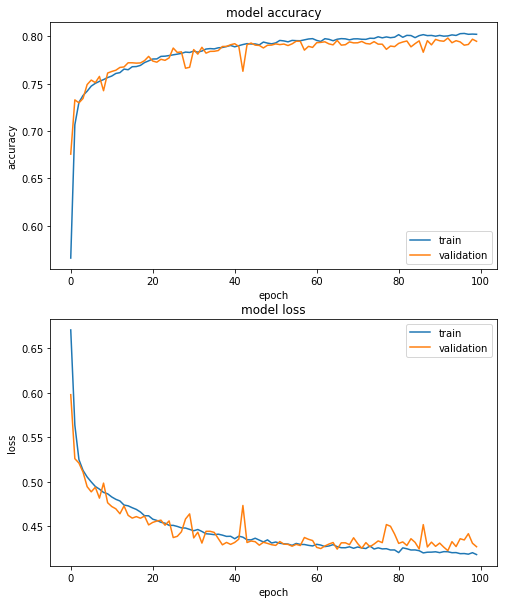

In [252]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.subplot(2,1,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [253]:
model.load_weights('weights//' + name + '/weights-improvement-93-0.80.hdf5')

In [254]:
# utility function for showing images
def show_imgs_mri(x_test, pred_label, true_label, n=4, rotate=False):
    plt.figure(figsize=(20, 12))
    num_img = x_test.shape[0]
    num_rows = 1 + num_img//n
    ix = 1
    for i in range(num_img):
        ax = plt.subplot(num_rows, n, ix)
        if rotate == True:
            temp = x_test[i].reshape(x_test.shape[1::])
            temp = np.rot90(temp)
            plt.imshow(temp)
        else:
            plt.imshow(x_test[i].reshape(x_test.shape[1::]))
        plt.title('Predicted: ' + str(pred_label[ix-1]) + '   True: ' + str(true_label[ix-1]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if ix == num_img: break
        ix += 1

    plt.show()

Randomly select some images in the validation set and show the label that the model predicts.

In [257]:
# Create a generator for the validation dataset
filename = 'datasets//' + name
X_identifier = 'k_space'
Y_identifier = 'label'
batch_size = 32
validation_generator = DataGenerator('validation', filename, 
                                     X_identifier, Y_identifier, 
                                     batch_size, sampling_percent, False)
# Extract a batch
batch_ix = 0
X, Y = validation_generator.__getitem__(batch_ix)

# Randomly select 4 indices
ixs = [np.random.randint(0, X.shape[0]) for i in range(4)]
input_data = X[ixs]
# Get the associated image and label for the selected indices
labels = validation_generator.get_data(batch_ix, 'label', ixs)
images = validation_generator.get_data(batch_ix, 'image', ixs)
k_space = validation_generator.get_data(batch_ix, 'k_space', ixs)

# Predict the classes of the selected indices
predicted = model.predict_classes(input_data)
print('Predicted: ', predicted)
print('Labels:   ', labels.T)

4/4 [==============================] - 0s 593us/step
Predicted:  [0 1 0 0]
Labels:    [[0 1 0 0]]


Show the k-space and image space data for the selected instances.

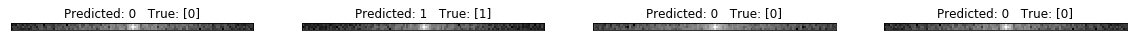

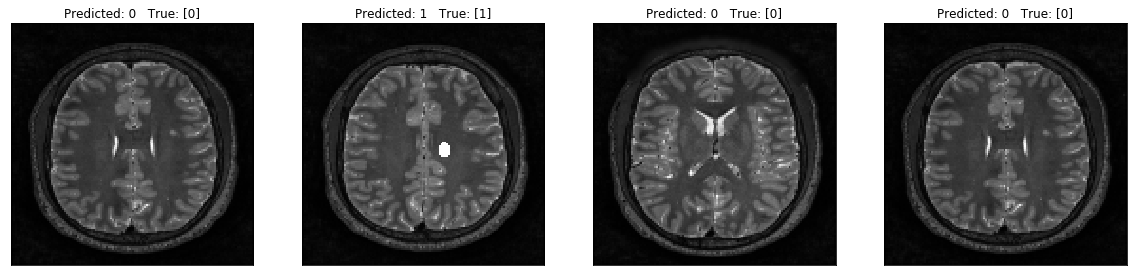

In [258]:
show_imgs_mri(np.log(np.abs(k_space)), predicted, labels, n=4)
show_imgs_mri(np.abs(images), predicted, labels, n=4, rotate = True)

# Get scores applying model to the training, validation and testing sets

Score contains the loss and the resulting accuracy

In [259]:
# Generators
filename = 'datasets//' + name
X_identifier = 'k_space'
Y_identifier = 'label'
batch_size = 32
training_generator = DataGenerator('train', filename, 
                                   X_identifier, Y_identifier, 
                                   batch_size, sampling_percent, False)
validation_generator = DataGenerator('validation', filename, 
                                     X_identifier, Y_identifier, 
                                     batch_size, sampling_percent, False)
test_generator = DataGenerator('test', filename, 
                               X_identifier, Y_identifier, 
                               batch_size, sampling_percent, False)

datasets = ['Training', 'Validation', 'Testing']
generators = [training_generator, validation_generator, test_generator]

In [260]:
for d, gen in zip(datasets, generators):
    score = model.evaluate_generator(gen, gen.num_batches)
    print(d + ' set: ' + str(score))

Training set: [0.37641807544578537, 0.8264265831593598]
Validation set: [0.4226198788370764, 0.7979957805907173]
Testing set: [0.4212123060177383, 0.7987139917695473]


Get the true positive, false positive, true negative and false negative rates using confusion matrix.

18960/18960 [==============================] - 1s 66us/step
[[69.68827836 30.31172164]
 [ 5.65575206 94.34424794]]


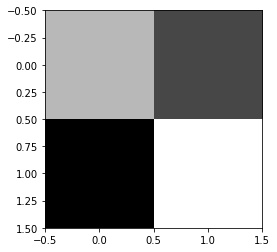

In [261]:
from sklearn.metrics import confusion_matrix

image = validation_generator.get_data_all('image')
k_space = validation_generator.get_data_all('k_space')
labels = validation_generator.get_data_all('label') 

X = np.stack((np.real(k_space), np.imag(k_space)), axis=-1)
X = X.astype('float32')
X = X/np.max(X)

y_hat = model.predict_classes(X, batch_size=32)

conf = confusion_matrix(labels, y_hat)
conf = (conf*100/np.sum(conf, axis=0)).T

print(conf)
plt.imshow(conf)
plt.show()

19440/19440 [==============================] - 1s 67us/step
[[68.79099583 31.20900417]
 [ 5.14608234 94.85391766]]


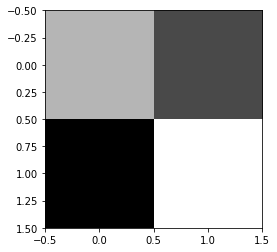

In [262]:
image = test_generator.get_data_all('image')
k_space = test_generator.get_data_all('k_space')
labels = test_generator.get_data_all('label')

X = np.stack((np.real(k_space), np.imag(k_space)), axis=-1)
X = X.astype('float32')
X = X/np.max(X)  

y_hat = model.predict_classes(X, batch_size=32)

conf = confusion_matrix(labels, y_hat)
conf = (conf*100/np.sum(conf, axis=0)).T

print(conf)
plt.imshow(conf)
plt.show()

In [207]:
print(labels.shape)
print(y_hat.shape)

(19920, 1)
(19920,)


# Get the images

Place images into files to access the FN, FP, TP and TNs.

In [110]:
from tqdm import tqdm_notebook as tqdm
import imageio
import warnings
import shutil

In [112]:
warnings.filterwarnings('ignore')

# Create the file structure which will containt the images
print('Creating file structure...')
if os.path.exists('images//'+name):
    shutil.rmtree('images//'+name)
os.makedirs('images//'+name)
os.makedirs('images//'+name+'//FP')
os.makedirs('images//'+name+'//FN')
os.makedirs('images//'+name+'//TP')
os.makedirs('images//'+name+'//TN')

# Predict the classes using the model
print('\nPredicting classes...')
truth = labels.reshape(len(labels),)

print('\nSaving images...')
for ix, i in enumerate(zip(tqdm(truth), y_hat)):
    files = {'FN': 'images//'+name+'//FN//', 
             'FP': 'images//'+name+'//FP//',
             'TP': 'images//'+name+'//TP//',
             'TN': 'images//'+name+'//TN//'}

    if i == (1,0): file = files['FN']   # False negative
    elif i == (0,1): file = files['FP'] # False positive
    elif i == (0,0): file = files['TN'] # True negative
    elif i == (1,1): file = files['TP'] # True positive
        
    imageio.imwrite(file + str(ix) + '.jpg', 
                        np.rot90(np.abs(image[ix])))

warnings.resetwarnings()

Creating file structure...

Predicting classes...

Saving images...


HBox(children=(IntProgress(value=0, max=4920), HTML(value='')))